# Generating Fair Counterfactuals by Uncovering Protected Attributes Through Cooperative Co-evolution
---
Kyle Spurlock & Miku Fukuyama

University of Louisville

CSE620 Fall 2022

# Data

In [ ]:
!wget https://raw.githubusercontent.com/kspurlock/ChWeiMo/main/tests/data/german_credit_data.csv

--2022-12-14 17:59:29--  https://raw.githubusercontent.com/kspurlock/ChWeiMo/main/tests/data/german_credit_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53393 (52K) [text/plain]
Saving to: ‘german_credit_data.csv’

german_credit_data. 100%[===================>]  52.14K  --.-KB/s    in 0.01s   

2022-12-14 17:59:30 (4.86 MB/s) - ‘german_credit_data.csv’ saved [53393/53393]



In [ ]:
!pip install dice_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 5.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools
import tqdm
import copy

In [ ]:
data = pd.read_csv("/content/german_credit_data.csv", delimiter=",").drop("Unnamed: 0", axis=1)
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


For future reference, good credit risk (what we want) is encoded as 1, bad credit risk is encoded as 0.

# ML Part

## Preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb =  LabelEncoder()

for column in data.columns:
    if data[column].dtype != np.dtype("int64"):
        data[column] = lb.fit_transform(data[column])

In [ ]:
X = data.iloc[:, :-1]
y = data.iloc[:, [-1]]
columns = X.columns.values
X.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,4,0,1169,6,5
1,22,0,2,1,0,1,5951,48,5
2,49,1,1,1,0,3,2096,12,3
3,45,1,2,0,0,0,7882,42,4
4,53,1,2,0,0,0,4870,24,1


In [ ]:
y

,Risk
0,1
1,0
2,1
3,1
4,0
...,...
995,1
996,1
997,1
998,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa04a0a3640>]],
      dtype=object)

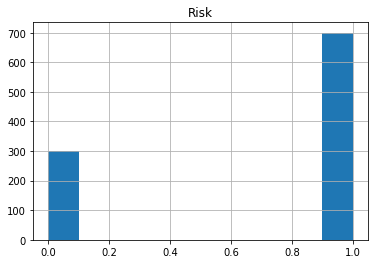

In [ ]:
y.hist()

## Learning a Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.20, random_state=22)

y_train = y_train.ravel()
y_test = y_test.ravel()

model = RandomForestClassifier(n_estimators=200, criterion="gini", random_state=9)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("Accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("F1 Score: %.2f" % f1_score(y_test, y_pred))
print("Precision Score: %.2f" % precision_score(y_test, y_pred))

Accuracy: 0.80
F1 Score: 0.87
Precision Score: 0.82


# Counterfactual Pedagogical Example

1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [ ]:
X.iloc[0,:]

Age                   67
Sex                    1
Job                    2
Housing                1
Saving accounts        4
Checking account       0
Credit amount       1169
Duration               6
Purpose                5
Name: 0, dtype: int64

In [ ]:
test_point = x_test[0]
test_point

array([  27,    0,    2,    1,    0,    0, 2389,   18,    5])

In [ ]:
model.predict_proba(test_point.reshape(1, -1) + [0, 0, 0, 0, 0, 0, 0, 0, 0])

array([[0.615, 0.385]])

In [ ]:
# So what I am demonstrating here is that if we change the gender to male
# and then change job to "highly skilled", we end up not being a credit risk

model.predict_proba(test_point.reshape(1, -1) + [0, 1, 1, 0, 0, 0, 0, 0, 0])

array([[0.29, 0.71]])

# Plotting

In [ ]:
def plot_history(population, extra):
  fig, ax = plt.subplots(1, 2, figsize=(10,7))

  cf_fitness = population.stats["cf"]
  bit_fitness = population.stats["bit"]

  num_gen = np.arange(len(cf_fitness["min"]))

  # Plot counterfactual fitness
  ax[0].plot(num_gen, cf_fitness["max"], label="Max", color="darkorange")
  ax[0].plot(num_gen, cf_fitness["mean"], label="Mean", color="seagreen")
  ax[0].plot(num_gen, cf_fitness["min"], label="Min", color="royalblue")

  ax[0].legend()
  ax[0].set_title("Counterfactual", fontsize=12,)
  ax[0].grid(axis="y")
  ax[0].set_ylabel("Fitness", fontsize=12, fontweight="bold")

  # Plot bit fitness
  ax[1].plot(num_gen, bit_fitness["max"], label="Max", color="darkorange")
  ax[1].plot(num_gen, bit_fitness["mean"], label="Mean", color="seagreen")
  ax[1].plot(num_gen, bit_fitness["min"], label="Min", color="royalblue")

  ax[1].set_title("Feature Mask", fontsize=12,)
  ax[1].grid(axis="y")

  fig.text(0.5, 0.04, "Generation", ha="center", fontsize=12, fontweight="bold")
  fig.text(0.91, 0.69, extra, ha="left")
  fig.suptitle("Species Fitness", y=0.95,fontweight="bold", fontsize=14)
  fig.show()

  return

In [ ]:
def plot_bit_inclusions(population, extra):
  best_map = population.pop["bit"][population.get_best(10, "bit")]
  feature_counts = np.sum(best_map, axis=0)
  sort_index = np.argsort(feature_counts)

  fig, ax = plt.subplots(1, figsize=(10,7))
  plt.barh(np.arange(9), feature_counts[sort_index], color="SeaGreen")
  plt.yticks(np.arange(9), columns[sort_index])
  plt.xlabel("Times Marked as Non-Protected", fontweight="bold", fontsize=12)
  plt.ylabel("Feature", fontweight="bold", fontsize=12)
  plt.title(f"Inclusions For Top 10 Feature Masks", fontweight="bold", fontsize=14)
  plt.text(10.6, 6.4, extra, ha="left")
  plt.show()
  return

In [ ]:
def plot_masked_prob(population, evaluator, extra):
  best_cf = population.pop["cf"][population.get_best(10, "cf")]
  best_map = population.pop["bit"][population.get_best(1, "bit")]

  desired_class = evaluator.desired_class
  x_orig = evaluator.x_orig

  best_combined = np.zeros((10,9), dtype="int32")
  for i, a in enumerate(best_combined):
    best_combined[i] = copy.deepcopy(x_orig)
    best_combined[i][best_map.astype(bool)[0]] = best_cf[i][best_map.astype(bool)[0]]

  cf_pred = evaluator.model_predict(best_cf)[:, desired_class]
  combined_pred = evaluator.model_predict(best_combined)[:, desired_class]

  width = 0.35
  x_marks = np.arange(10)
  fig, ax = plt.subplots(1, figsize=(10,7))

  rects1 = ax.barh(x_marks - width/2, cf_pred[::-1], width, label="$x'$", color="grey")
  rects1 = ax.barh(x_marks + width/2, combined_pred[::-1], width, label="$x'_B$", color="turquoise")
  plt.ylabel("Counterfactuals (sorted descending)", fontsize=12, fontweight="bold")
  plt.xlabel("Probability for Desired Class", fontsize=12, fontweight="bold")

  plt.title(f"Induced Change in Probability for $y^C$ from Masks", fontweight="bold", fontsize=14)
  plt.legend()
  plt.axvline(0.5, linestyle="--", color="black")


  fig.text(0.91, 0.69, extra, ha="left")
  fig.show()

# Genetic Algorithm

# Algorithm Components
---

## Algorithm Constants

In [ ]:
# Need to find the bounds for each of the features to generate random solutions
# and also perform bounded mutation

def collect_bounds(X):
  """
  Collects bounds for each feature as a 2-d matrix.

  Row index 0 contains lower bounds, row index 1 contains upper bounds
  """

  bound = np.ones((2, X.shape[1]), dtype=np.int32)
  bound[0] = X.min(axis=0)
  bound[1] = X.max(axis=0)
  return bound 

#bound = collect_bounds(X)
#bound

In [ ]:
"""
discrete_map = bound[1] < 10
continuous_map = np.logical_not(discrete_map)
feature_map = {
"continuous": continuous_map,
"discrete": discrete_map
                }
"""

'\ndiscrete_map = bound[1] < 10\ncontinuous_map = np.logical_not(discrete_map)\nfeature_map = {\n"continuous": continuous_map,\n"discrete": discrete_map\n                }\n'

## Population

In [ ]:
def init_cf_pop(pop_size, num_dim, bound, rand_gen):
  """
  Initializes the counterfactual population
  """

  population = np.zeros((pop_size, num_dim), dtype=np.int32)
  for i in range(num_dim):
    population[:, i] = rand_gen.integers(bound[0][i],
                                         bound[1][i]+1,
                                         size=(pop_size))

  return population

def init_bit_pop(pop_size, num_dim, rand_gen):
  """
  Initializes the bit mask population
  """

  population = np.zeros((pop_size, num_dim), dtype=np.int32)

  for i in range(pop_size):
    keep_var = rand_gen.integers(0, num_dim, (5,)) # 5 is totally variable here, just determines how many variables to keep
    population[i][keep_var] = 1

  return population

class Population():
  def __init__(self, pop_size, num_dim, compute_bound_on, seed):
    self.shape = (pop_size, num_dim)
    self.rand_gen = np.random.default_rng(seed)

    # Get the bounds (presumably from X)
    self.bound = collect_bounds(compute_bound_on)
    
    # Populations
    self.pop = {
        "cf": init_cf_pop(*self.shape, self.bound, self.rand_gen),
        "bit": init_bit_pop(*self.shape, self.rand_gen)
    }

    # Fitnesses
    self.fitness = {
        "cf": None,
        "bit": None
    }

    # Bookkeeping
    self.stats = {
        "cf": {"min":[], "max":[], "mean":[]},
        "bit": {"min":[], "max":[], "mean":[]}
        }

    self.history = {
        "cf": [],
        "bit": []
    }

  def set_fitness(self, new_fitness, which):
    if which == "both":
      assert len(new_fitness) == 2, "Must have both fitnesses packaged in an iterable to set both"
      self.fitness["cf"] = new_fitness[0]
      self.fitness["bit"] = new_fitness[1]
    else:
      self.fitness[which] = new_fitness

  def get_best(self, k, which):
    assert self.fitness[which] is not None, "Cannot return best with unitialized fitness"
    return np.argsort(self.fitness[which])[::-1][:k]

  def record_stats(self):
    assert self.fitness["cf"] is not None, "Cannot report statistics of uninitialized fitness"
    assert self.fitness["bit"] is not None, "Cannot report statistics of uninitialized fitness"

    for species in self.stats.keys():
      min = self.fitness[species].min()
      max = self.fitness[species].max()
      mean = self.fitness[species].mean()

      print("\n", f"Species:{species}")
      print("-"*30)
      print(f"\t Min: {min}")
      print(f"\t Max: {max}")
      print(f"\t Mean: {mean}")
      print("-"*30, "\n")

      self.stats[species]["min"].append(min)
      self.stats[species]["max"].append(max)
      self.stats[species]["mean"].append(mean)

  def save_pop(self):
    self.history["cf"].append(copy.deepcopy(self.pop["cf"]))
    self.history["bit"].append(copy.deepcopy(self.pop["bit"]))


pop = Population(20, 9, X.values, 192)

#pop = init_cf_pop(30, 9, bound, rand_gen)
#pop[:5]

#bit_pop = init_bit_pop(pop_size, num_dim, rand_gen)
#bit_pop[:5]

## Fitness

In [ ]:
def compute_MAD(X):
  """Compute the Median Absolute Deviation (MAD) for each feature.

  Args:
      X (np.ndarray): n x m matrix (n samples, m features)

  Returns:
      MAD (np.ndarray): vector of m deviations from the median corrosponding to m features
  """
  num_dim = X.shape[1]
  MAD = np.zeros(num_dim)

  # Computes the median of each feature
  feature_wise_median = np.median(X, axis=0).astype(np.int32)

  for i in range(num_dim):
    # Compute absolute deviation
    deviation = np.abs(X[:, i] - feature_wise_median[i])
    MAD[i] = np.median(deviation)


  # Replace any zeros with 1 (avoids division errors)
  MAD[np.where(MAD == 0)[0]] = 1

  return MAD

#print("Without MAD: %.2f" % l1_distance(pop[0], x_orig))
#print("With MAD: %.2f" % l1_distance(pop[0], x_orig, MAD))

### Evaluator

In [ ]:
class Evaluator():
  def __init__(self, x_orig, desired_class, model_predict, compute_MAD_on=None):
    self.x_orig = x_orig
    self.num_dim = x_orig.shape[0]
    self.desired_class = desired_class
    self.model_predict = model_predict

    if compute_MAD_on is not None:
      self.MAD = compute_MAD(compute_MAD_on)
    else:
      self.MAD = None
  
  def l1_distance(self, x_prime, x_orig):
    """Computes L1 distance between x' and x.
        
    Args:
        x_prime (iterable): Potential solution (counterfactual) from the optimization
        x_orig (iterable): Original instance being explained
        MAD (iterable, optional): The median absolute deviations for each feature. Defaults to None

    Returns:
        float: The cost for this objective
    """
    distance = np.abs(x_prime - x_orig)

    if self.MAD is not None:
      return np.sum(distance / self.MAD)
    else:
      return np.sum(distance)

  def tanimoto(self, string1, string2):
    """
    Computes Tanimoto similarity between two bit strings (masks)
    """
    top = np.logical_and(string1, string2)
    bottom = np.logical_or(string1, string2)

    return np.sum(top)/np.sum(bottom)

  def compute_combined_fit(self, cf_species, bit_species):
    """
    Computes the combined fitness and divides it amongst the elements of the species

    The fitness measure for each species is computed as an aggregated evaluation
    from one solution of one species, to all the other solutions to the other
    species.

    Meaning that one counterfactual will have fitness aggregated across all maps that
    are passed, and one bit mask will have fitness aggregated across all counterfactuals
    that are passed.

    Hopefully this means that if both populations want to succeed, they will have
    to evolve together. 
    """

    fitness = np.zeros(shape=(cf_species.shape[0], bit_species.shape[0]))

    # Preliminary values related to the constraints of each species
    x_prime_yh = self.model_predict(cf_species)[:, self.desired_class]

    # Find out how many features are in each bit mask
    bit_count = np.sum(bit_species, axis=1)

    for i, x_prime in enumerate(cf_species):
      combined_solution = x_prime.copy()
      cf_fitness = 1/self.l1_distance(x_prime, self.x_orig)
      yh = self.model_predict(
          x_prime.reshape(1,-1)
          )[:, desired_class]


      for j, mask in enumerate(bit_species):
        # These features need to be the same as x_orig
        not_mask = np.logical_not(mask)

        # Build a combined solution using values from x_orig and x_prime
        combined_solution[not_mask.astype(bool)] = self.x_orig[not_mask.astype(bool)]
        combined_solution[mask.astype(bool)] = x_prime[mask.astype(bool)]

        # Get the probability for the desired class of the combined counterfactual
        combined_yh = self.model_predict(
            combined_solution.reshape(1,-1)
            )[:, desired_class]

        yh_dif = (combined_yh - x_prime_yh[i])[0]

        # If the prediction stays the same, change to 10 to avoid division error
        if yh_dif == 0:
          yh_dif = 10

        else:
          yh_dif = 1/yh_dif
        
        # Explanation:
        # The sum of the inverted mask is here to weight the difference in prediction
        # given how many features we are taking away. Obviously, taking many features away
        # can be detrimental to the prediction, so we don't necessarily want to punish the mask
        # for doing so.

        # The 1e-3 is just a normalization constant to keep this in line with the
        # magnitude of the distance

        yh_dif = yh_dif * (self.num_dim-bit_count[j]) * 1e-3

        fitness[i][j] = cf_fitness + yh_dif

    # Compute the species fitness for the counterfactuals
    cf_fitness = np.median(fitness, axis=1)
    dif = x_prime_yh - 0.501
    infeasible = np.where(dif < 0)[0]
    cf_fitness[infeasible] = -dif[infeasible]*cf_fitness[infeasible]*0.50

    # Compute the species fitness for the bit masks
    bit_fitness = np.median(fitness, axis=0)
    infeasible = np.where((bit_count < 3) | (bit_count > 7))[0]

    # 5 - bit_count here and then exponential is to create kind of a parabolic
    # step function for the penalty.
    bit_fitness[infeasible] = bit_fitness[0]*(np.power(5-bit_count[0], 2))*0.025

    return cf_fitness, bit_fitness


#evaluator = Evaluator(x_orig, desired_class, model.predict_proba, compute_MAD_on=X.values)

#fitness = evaluator.compute_combined_fit(pop.pop["cf"], pop.pop["bit"])
#pop.set_fitness(fitness, "both")

## Operators

### Selection

In [ ]:
def random_selection(fitness, num_mating=-1, rand_gen=None):
  """
  Randomly select solutions with no regards to their fitness.
  For crowding, need to randomly select (basically shuffle) all solutions
  and then mate them.
  """

  if num_mating == -1:
    N = len(fitness)
  else:
    N = num_mating

  selected = rand_gen.choice(
              np.arange(len(fitness)),
              size=(N,),
              replace=False,
              )
  
  return selected
  
#selected = random_selection(fitness, rand_gen=rand_gen)
#selected

In [ ]:
#selection = random_selection(pop.fitness["cf"], num_mating=10, rand_gen=rand_gen)
#selection

### Crossover

In [ ]:
def SBX(parent1, parent2, eta, rand_gen):
  """
  Performs simulated binary crossover from:
  https://sci-hub.ru/10.1145/1276958.1277190

  Imitates binary crossover on real-valued strings
  using a probability distribution similar to single point crossover.
  """
  u = rand_gen.random()

  if u <= 0.50:
    Bq = pow(2*u, 1/(eta+1))
  else:
    Bq = pow(1/(2*(1-u)), 1/(eta+1))

  child1 = np.round(0.5*((1+Bq)*parent1 + (1-Bq)*parent2), 0).astype(np.int32)
  child2 = np.round(0.5*((1-Bq)*parent1 + (1+Bq)*parent2), 0).astype(np.int32)

  return (child1, child2)

#SBX(pop[0], pop[1], eta=15, rand_gen=rand_gen)

In [ ]:
def one_point_cross(parent1, parent2, rand_gen):
  """
  Performs one point crossover
  """
  
  length = len(parent1)

  # Find split point (leaving sign bit alone)
  cut = rand_gen.integers(1, length-2)

  # Produce children
  child1 = np.concatenate((parent1[0:cut], parent2[cut:length]))
  child2 = np.concatenate((parent2[0:cut], parent1[cut:length]))

  assert len(child1) == len(child2) == len(parent1)

  return (child1, child2)

#one_point_cross(pop[0], pop[1], rand_gen=rand_gen)

### Mutation

In [ ]:
def bit_mut(solution, Pm, rand_gen):
  """
  Performs mutation working on a bit string. This is only applicable to
  the bit map population.
  """
  
  sol_copy = solution.copy()

  for i, bit in enumerate(sol_copy):
    if Pm > rand_gen.random():
      if bit == 1:
        sol_copy[i ]= 0
      else:
        sol_copy[i] = 1

  return sol_copy

"""
for o, m in zip(pop.pop["bit"][0], bit_mut(pop.pop["bit"][0], 0.3, rand_gen=rand_gen)):
  if o != m:
    print("Mutated")
"""

'\nfor o, m in zip(pop.pop["bit"][0], bit_mut(pop.pop["bit"][0], 0.3, rand_gen=rand_gen)):\n  if o != m:\n    print("Mutated")\n'

In [ ]:
def poly_mut(solution, bound, feature_map, eta, Pm, rand_gen):
  """
  Implements polynomial mutation from PyMoo library:
  https://github.com/anyoptimization/pymoo/blob/main/pymoo/operators/mutation/pm.py

  Or better yet:
  https://www.researchgate.net/profile/Bilal-Abed-Alguni/publication/330967534_Island-based_Cuckoo_Search_with_Highly_Disruptive_Polynomial_Mutation/links/5c740b59458515831f6fcf32/Island-based-Cuckoo-Search-with-Highly-Disruptive-Polynomial-Mutation.pdf

  But the problem here is that polynomial mutation only really works on
  real-valued chromosomes. For instance, it is extremely unlikely that gender
  will ever be mutated in the counterfactual. So this implementation performs
  PM only on the continuous genes, but uniform discrete mutation on the others.
  """
  mutate_index = (rand_gen.random(solution.shape) < Pm).astype(np.int32)

  if sum(mutate_index) == 0:
    # Case where no mutation occurs
    return solution
  
  else:
    # Perform continuous mutation via PM
    delta1 = (solution - bound[0]) / (bound[1] - bound[0])
    delta2 = (bound[1] - solution) / (bound[1] - bound[0])
    mut_power = 1.0 / (eta + 1.0) # μ_m in the pseudocode

    rand = rand_gen.random(solution.shape)
    mask = rand <= 0.5
    mask_not = np.logical_not(mask)

    deltaq = np.zeros(solution.shape)

    xy = 1.0 - delta1
    val = 2.0 * rand + (1.0 - 2.0 * rand) * (np.power(np.abs(xy), (eta + 1.0)))
    d = np.power(np.abs(val), mut_power) - 1.0
    deltaq[mask] = d[mask]

    xy = 1.0 - delta2
    val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (np.power(np.abs(xy), (eta + 1.0)))
    d = 1.0 - (np.power(np.abs(val), mut_power))
    deltaq[mask_not] = d[mask_not]

    # Only applies the mutation to the continuous features that have passed the
    # mutation criterion
    new_sol = solution + (feature_map["continuous"]*mutate_index*(deltaq * (bound[1] - bound[0])))
    new_sol = np.round(new_sol, 0).astype(np.int32)

    # Ensures that resulting new solution is within the bounds
    new_sol[new_sol < bound[0]] = bound[0][new_sol < bound[0]]
    new_sol[new_sol > bound[1]] = bound[1][new_sol > bound[1]]

    # Perform discrete mutation uniformly at random
    for i, is_discrete in enumerate(feature_map["discrete"]):
      if is_discrete and mutate_index[i]:
        new_sol[i] = rand_gen.integers(bound[0][i], bound[1][i]+1)
    
    return new_sol
"""
for o, m in zip(pop.pop["cf"][0], poly_mut(pop.pop["cf"][0], bound, feature_map, 2, 1, rand_gen=rand_gen)):
  print(o, m)
"""

'\nfor o, m in zip(pop.pop["cf"][0], poly_mut(pop.pop["cf"][0], bound, feature_map, 2, 1, rand_gen=rand_gen)):\n  print(o, m)\n'

### Reproduction

#### Reproducer

In [ ]:
class Reproducer():
  def __init__(self, Pc, Pm, eta, seed):
    self.Pc = Pc
    self.Pm = Pm
    self.eta = eta
    self.rand_gen = np.random.default_rng(seed)

    # Will need to set these from population class (has coupling)
    self.bound = None
    self.feature_map = None

  def set_pop_params(self, population):
    self.bound = population.bound

    # Set up the feature map (for mutation)
    discrete_map = self.bound[1] < 10
    continuous_map = np.logical_not(discrete_map)

    self.feature_map = {
        "continuous": continuous_map,
        "discrete": discrete_map
                        }

  def reproduce(self, population, selection, evaluator, main_species):
    """
    Perform reproduction on counterfactuals
    """
    # Get 10 best of other species
    if main_species == "cf":
      other_species = "bit"
      
    elif main_species =="bit":
      other_species = "cf"

    best_other_species = population.pop[other_species][population.get_best(10, other_species)]

    first_parents = selection[:len(selection)//2]
    second_parents = selection[len(selection)//2:]

    replacements = {}
    child_fitness = {}

    for p1, p2 in zip(first_parents, second_parents):
      if self.Pc > self.rand_gen.random():
        # Grab the parents from the population
        parent1 = population.pop[main_species][p1]
        parent2 = population.pop[main_species][p2]

        # Perform mating operations
        if main_species == "cf":
          # Perform crossover for COUNTERFACTUALS
          children = SBX(parent1, parent2, self.eta, self.rand_gen)

          # Perform mutation for COUNTERFACTUALS
          children = np.array(list(map(
              functools.partial(poly_mut,
                                bound=self.bound,
                                feature_map=self.feature_map,
                                eta=self.eta,
                                Pm=self.Pm,
                                rand_gen=self.rand_gen), children)
          ))

          # Compute fitness for COUNTERFACTUALS
          child_fit = evaluator.compute_combined_fit(cf_species=children,
                                            bit_species=best_other_species)[0]
        
        elif main_species == "bit":
          # Perform crossover for BIT MASKS
          children = one_point_cross(parent1, parent2, self.rand_gen)

          # Perform mutation for BIT MASKS
          children = np.array(list(map(
              functools.partial(bit_mut,
                                Pm=self.Pm,
                                rand_gen=self.rand_gen), children)
          ))

          # Compute fitness for BIT MASKS
          child_fit = evaluator.compute_combined_fit(cf_species=best_other_species,
                                            bit_species=children)[1]
        else:
          raise ValueError

        # Mark the population indices for replacement
        replacements[(p1, p2)] = (children[0], children[1])

        # Store the fitness of the children (easier for niching/don't need to recompute all fitness every iteration)
        child_fitness[(p1, p2)] = (child_fit[0], child_fit[1])

    return replacements, child_fitness



#repro = Reproducer(0.95, 0.03, 15, 192)
#repro.set_pop_params(pop)

#replacements, child_fitness = repro.reproduce(pop, selection, evaluator, main_species="bit")

### Niching

In [ ]:
def RTS(population, evaluator, replacements, child_fitness, window_size, main_species):
  """
  Implements restricted tournament search from:
  https://arxiv.org/pdf/2201.06485.pdf
  
  Effectively what needs to be done here is to do the reproduction, and then compare
  each child with the smallest
  """

  new_replacements = {}
  new_child_fitness = {}

  fitness = population.fitness[main_species]
  rand_gen = population.rand_gen

  for parents, children, in replacements.items():
    for child, child_fit in zip(children, child_fitness[parents]):
      sample = rand_gen.choice(
              np.arange(len(fitness)),
              size=(window_size,),
              replace=False,
              )

      min_dist = np.inf
      min_index = None

      for pop_index in sample:
        replacing_solution = population.pop[main_species][pop_index]

        if main_species == "cf":
          dist = evaluator.l1_distance(child, replacing_solution)

        elif main_species == "bit":
          dist = 1-evaluator.tanimoto(child, replacing_solution) # Tanimoto disimilarity

        if dist < min_dist:
          min_dist = dist
          min_index = pop_index

      if child_fit > fitness[min_index]:
        new_replacements[(min_index, )] = np.array([child])
        new_child_fitness[(min_index, )] = np.array([child_fit], dtype=np.float32)

  return new_replacements, new_child_fitness

#replacements, child_fitness = RTS(pop, evaluator, replacements, child_fitness, 5, main_species="bit")

## Putting It All Together

In [ ]:
def genetic_algorithm(population,
                      evaluator,
                      reproducer,
                      num_gen,
                      num_mating,
                      **kwargs):

  window_size = population.shape[0]


  first_fit = evaluator.compute_combined_fit(population.pop["cf"],
                                             population.pop["bit"])
  population.set_fitness(first_fit, "both")

  population.save_pop()
  population.record_stats()

  for gen in tqdm.trange(num_gen):
    for species in ["cf", "bit"]:
      # Perform selection
      selection = random_selection(population.fitness[species],
                                   num_mating,
                                   population.rand_gen)

      # Perform reproduction
      replacements, child_fitness = reproducer.reproduce(population,
                                                         selection,
                                                         evaluator,
                                                         main_species=species)
      
      # Perform restricted tournament selection
      replacements, child_fitness = RTS(population,
                                        evaluator,
                                        replacements,
                                        child_fitness,
                                        window_size,
                                        main_species=species)
      
      # Perform replacement
      for k in replacements.keys():
        # Replace p1 with c1
        population.pop[species][k[0]] = replacements[k][0]
        population.fitness[species][k[0]] = child_fitness[k][0]

    population.record_stats()
  
  population.save_pop()

  return population




# Evaluation

## Single Examples - CCGA

In [ ]:
x_orig = x_test[4]
desired_class = np.argmin(model.predict_proba(x_orig.reshape(1,-1)), axis=1)
desired_class

array([0])

In [ ]:
pop = Population(pop_size=30,
                 num_dim=9,
                 compute_bound_on=X.values,
                 seed=432)

evaluator = Evaluator(x_orig=x_orig,
                      desired_class=desired_class,
                      model_predict=model.predict_proba,
                      compute_MAD_on=X.values)

reproducer = Reproducer(Pc=0.95,
                        Pm=0.3,
                        eta=15,
                        seed=432)

reproducer.set_pop_params(pop)

pop = genetic_algorithm(pop, evaluator, reproducer, num_gen=50, num_mating=-1)

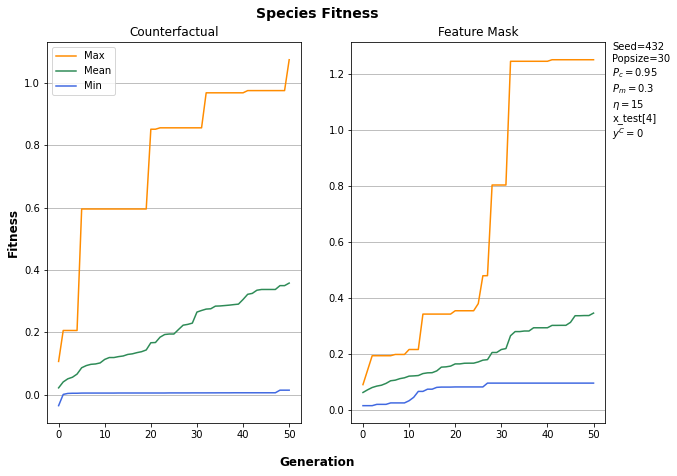

In [ ]:
extra = "Seed=432\nPopsize=30\n$P_c=0.95$\n$P_m=0.3$\n$\eta=15$\nx_test[4]\n$y^C=0$"
plot_history(pop, extra)

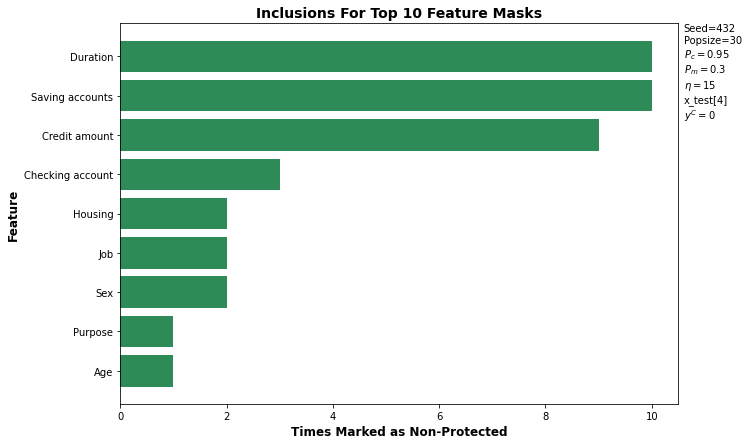

In [ ]:
plot_bit_inclusions(pop, extra)

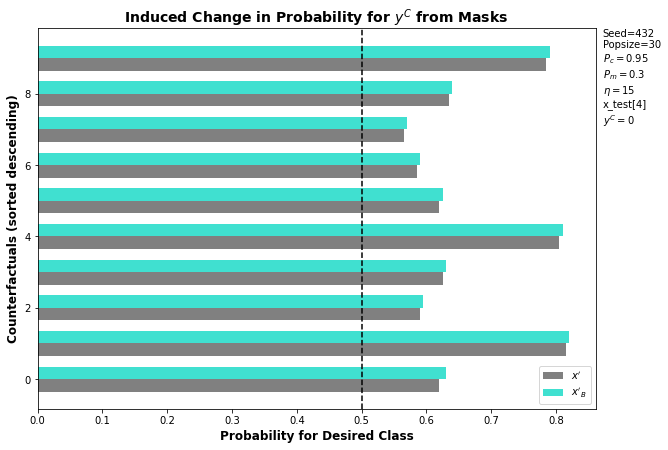

In [ ]:
plot_masked_prob(pop, evaluator, extra)

In [ ]:
evaluator.x_orig

array([  20,    0,    2,    2,    0,    0, 1282,   12,    4])

In [ ]:
pop.pop["bit"][pop.get_best(10, "bit")]

array([[0, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 0, 1, 1, 0],
       [0, 1, 0, 0, 1, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 1, 1, 0]], dtype=int32)

In [ ]:
pop.pop["cf"][pop.get_best(10, "cf")]

array([[   19,     0,     2,     2,     0,     0, 10765,    40,     4],
       [   30,     0,     2,     0,     3,     0,  1800,    63,     4],
       [   33,     0,     2,     2,     2,     0, 13932,    15,     0],
       [   33,     0,     3,     2,     4,     0,  5141,    65,     0],
       [   41,     0,     2,     0,     3,     0,  8834,    52,     4],
       [   23,     0,     3,     2,     1,     0,   856,    52,     3],
       [   20,     1,     2,     2,     1,     3, 16049,    21,     0],
       [   55,     0,     1,     0,     4,     0, 12585,    41,     4],
       [   23,     0,     2,     2,     0,     0,  3409,    53,     1],
       [   60,     0,     3,     0,     4,     0,  6012,    51,     7]],
      dtype=int32)

In [ ]:
model.predict_proba(x_test[4].reshape(1,-1))

array([[0.435, 0.565]])

In [ ]:
x_test[4]

array([  20,    0,    2,    2,    0,    0, 1282,   12,    4])

## Single Examples - DiCE

In [ ]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,4,0,1169,6,5,1
1,22,0,2,1,0,1,5951,48,5,0
2,49,1,1,1,0,3,2096,12,3,1
3,45,1,2,0,0,0,7882,42,4,1
4,53,1,2,0,0,0,4870,24,1,0


In [ ]:
import dice_ml  

d = dice_ml.Data(dataframe=data,
                 continuous_features=["Age", "Credit amount", "Duration"],
                 discrete_features = ["Sex", "Job", "Housing", "Savings accounts", "Checking account", "Purpose"],
                 outcome_name="Risk")


dice_model = dice_ml.Model(model=model, backend="sklearn") 

In [ ]:
point = pd.DataFrame(x_test[4].reshape(1,-1), columns=data.iloc[:, :-1].columns)

In [ ]:
exp_random = dice_ml.Dice(d, dice_model, method="random") 

dice_exp_random = exp_random.generate_counterfactuals(point, total_CFs=5, desired_class=0, verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomFore

Diverse Counterfactuals found! total time taken: 00 min 01 sec


In [ ]:
point.values

array([[  20,    0,    2,    2,    0,    0, 1282,   12,    4]])

In [ ]:
dice_exp_random.cf_examples_list[0].final_cfs_df.values

array([[   20,     0,     0,     2,     0,     0,  1282,    69,     4,
            0],
       [   20,     0,     2,     2,     0,     0, 12230,    12,     4,
            0],
       [   20,     0,     2,     2,     3,     0, 18336,    12,     4,
            0],
       [   20,     0,     2,     2,     0,     0, 17464,    12,     4,
            0],
       [   20,     0,     2,     2,     2,     0, 18233,    12,     4,
            0]])

## Aggregation

In [ ]:
test_rng = np.random.default_rng(453)
random_sample = test_rng.choice(x_test[np.where(y_pred == 0)[0]], size=(10, ), replace=False)
test_desired_class = np.argmin(model.predict_proba(random_sample), axis=1)
test_desired_class

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
all_bit_masks = np.full((1, 9), np.inf)

for x_orig, desired_class in zip(random_sample, test_desired_class):

  pop = Population(pop_size=30,
                  num_dim=9,
                  compute_bound_on=X.values,
                  seed=192)

  evaluator = Evaluator(x_orig=random_sample,
                        desired_class=desired_class,
                        model_predict=model.predict_proba,
                        compute_MAD_on=X.values)

  reproducer = Reproducer(Pc=0.95,
                          Pm=0.3,
                          eta=15,
                          seed=192)

  reproducer.set_pop_params(pop)

  pop = genetic_algorithm(pop, evaluator, reproducer, num_gen=50, num_mating=-1)

  all_bit_masks = np.concatenate((all_bit_masks, pop.pop["bit"][pop.get_best(10, "bit")].copy()), axis=0)

In [ ]:
np.sum(np.delete(all_bit_masks, 0, axis=0), axis=0)

array([50., 41., 44., 26., 43., 87., 35., 20., 34.])

In [ ]:
def plot_bit_inclusions(feature_counts, extra):
  sort_index = np.argsort(feature_counts)

  fig, ax = plt.subplots(1, figsize=(10,7))
  plt.barh(np.arange(9), feature_counts[sort_index], color="darkorange")
  plt.yticks(np.arange(9), columns[sort_index])
  plt.xlabel("Times Marked as Non-Protected", fontweight="bold", fontsize=12)
  plt.ylabel("Feature", fontweight="bold", fontsize=12)
  plt.title(f"Aggregated Inclusions For Top 10 Feature Mask", fontweight="bold", fontsize=14)
  plt.text(10.6, 6.4, extra, ha="left")
  plt.show()
  return

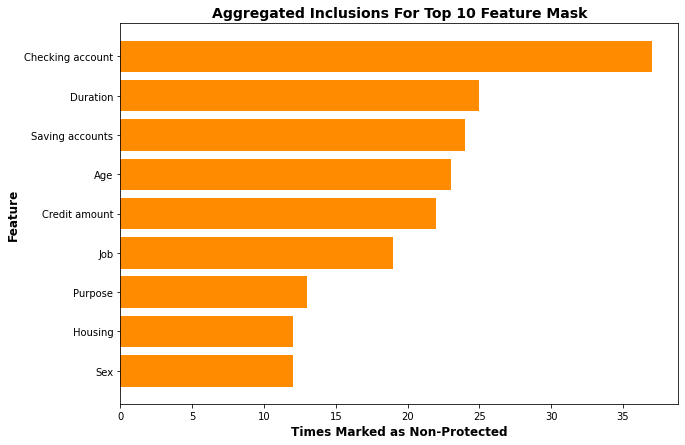

In [ ]:
plot_bit_inclusions(np.sum(np.delete(all_bit_masks, 0, axis=0), axis=0), "")